### TO CLEAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


In [2]:
__author__ = 'nipunbatra'

import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("../main_15min_decomposition_12_daily_weekly_cluster_diff_frac_temp_weekday_hvac_energy.csv",index_col=0)
dfc = df.copy()

df = df.drop(871)
df = df.drop(1169)



w=df[['aggregate_%d' %i for i in range(1,13)]]

df = df.ix[w[w>0].dropna().index]

"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',}
                       #'month_extract':['variance','ratio_min_max', 'difference_min_max',
                        #                'ratio_difference_min_max']}

"""
features_individual = {'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],

                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'cluster_big':'cluster_big',
                       'cluster_small':'cluster_small',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'week':["fraction_%d" % i for i in range(1, 8)],
                       #'disag_fridge':'disag_fridge'}
                       'mins_hvac':'mins_hvac',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

### Monthly ONLY
"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       #'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       #'trend_12':['stdev_trend_12','max_trend_12'],
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       #'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       #'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',
                       #'cluster_big':'cluster_big',
                       #'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}


"""

from itertools import combinations
features_dict = {}
for feature_size in range(1,max(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()



hvac_fhmm_pred = pd.read_csv("../fhmm_disag_new.csv", index_col=0)
fridge_fhmm_pred = pd.read_csv("../fridge_fhmm.csv", index_col=0)
appliance_fhmm = {'fridge': fridge_fhmm_pred,
                  'hvac': hvac_fhmm_pred}

national_average = {"fridge": 0.07, "hvac": 0.18, 'wm': 0.01, 'furnace': 0.09, 'dw': 0.02, 'dr': 0.04, 'light': .11}

def scale_min_max(ser, minimum=-1, maximum=1):
    ser_min = ser.min()
    ser_max = ser.max()
    return minimum + ((maximum-minimum)*(ser-ser_min))/(ser_max-ser_min)
    

def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

#Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].min().min()
df[["aggregate_%d" % i for i in range(1, 13)]] = scale_0_1(df[["aggregate_%d" % i for i in range(1, 13)]], min_aggregate, max_aggregate)


max_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].max().max()
min_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].min().min()
df[["daily_usage_%d" % i for i in range(1, 8)]] = scale_0_1(df[["daily_usage_%d" % i for i in range(1, 8)]], min_weekly, max_weekly)

df['area'] = scale_0_1(df['area'])

df['num_rooms'] = scale_0_1(df['num_rooms'])
df['total_occupants'] = scale_0_1(df['total_occupants'])
df['mins_hvac'] =  scale_0_1(df['mins_hvac'])

# Adding new feature
aa = df[["aggregate_%d" % i for i in range(1, 13)]].copy()
df['variance'] = df[["aggregate_%d" % i for i in range(1, 13)]].var(axis=1)
df['ratio_min_max'] = aa.min(axis=1)/aa.max(axis=1)


df['difference_min_max'] = aa.max(axis=1)-aa.min(axis=1)
df['ratio_difference_min_max'] = (aa.max(axis=1)-aa.min(axis=1)).div(aa.max(axis=1))


for col in ["stdev_trend_12","stdev_seasonal_12","max_seasonal_12","max_trend_12",
            "stdev_trend_daily","stdev_seasonal_daily","max_seasonal_daily","max_trend_daily",
            "stdev_trend_weekly","stdev_seasonal_weekly","max_seasonal_weekly","max_trend_weekly","disag_fridge",
            'stdev_trend','stdev_seasonal','max_seasonal','max_trend',
            'cluster_small','cluster_big', 'temperature_corr', 'variance',
            'ratio_min_max','ratio_difference_min_max','seasonal_energy_5','seasonal_energy_6',
            'seasonal_energy_7','seasonal_energy_8','seasonal_energy_9','seasonal_energy_10']:
    if col in df.columns:

        df[col] = scale_0_1(df[col])



dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]
    print appliance, len(dfs[appliance])

appliance_min = {'fridge':5,'hvac':5,'wm':0,'dw':0,'dr':0,'light':0}

all_homes = {
    'dw':[  94,  370,  545,  624, 2156, 2242, 2814, 2829, 3723,
            4767, 5357,6636, 6910, 7769, 9934],
    'wm':[  94,  370,  545,  624, 2156, 2242, 2814, 3367, 3456, 3723, 3967,
            5357, 7769, 9654, 9922, 9934],
    'hvac':[  26,   94,  370,  410,  545,  624, 1283, 1642, 1953, 2129,
            2156, 2242, 2470, 2814, 2829,  3367, 3456, 3723,
            3967, 4767, 5218, 5357, 5371, 5746, 5785, 5814, 6072,
            6636, 6836, 6910, 7731, 7769, 7866, 9609, 9654, 9922, 9933, 9934],
    'fridge':[  94,  370,  410,  545,  624, 1953, 2156, 2242, 2814, 2829, 3367,
            3456, 3723, 3967, 4767, 5357, 5371, 6072, 6636, 6910, 7769, 7866],
    'light':df.index.tolist(),
        #[ 624, 1334, 2814, 2925, 2986, 3367, 3456, 3482, 3723, 3967, 4732,
        #    4767, 5814, 5817, 6072, 6266, 6910, 7016, 7429, 7731, 7769, 7866,
        #    8317, 8626, 9052, 9654, 9922],
    'dr':[  94,  370,  410, 2156, 2242, 2814, 3456, 3723, 4767,
            5785, 5814, 6072, 6636, 6836, 7731, 7769, 7866, 9654, 9922,
            9933, 9982]
}

all_homes = {appliance:dfs[appliance].index for appliance in dfs.keys()}

all_homes['fridge'] = np.array(np.setdiff1d(all_homes['fridge'], [2233, 5746, 7016]))
all_homes['hvac'] = np.array(np.setdiff1d(all_homes['hvac'], [252, 2925, 2986, 3482, 4732, 5439, 6266,
                                                              8626, 1800, 2233, 5817, 7016, 7429, 8317,
                                                              9052, 9982]))

all_homes['dw'] =  np.array(np.setdiff1d(all_homes['dw'],[2233, 7016]))

all_homes['wm'] = np.array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
            3967, 5357, 7769, 9654, 9922, 9934])


all_homes['light']=[624, 1334, 3367, 3456, 3723, 5814, 6072, 6910, 7769, 7866, 9654,
            9922]



fridge 30
hvac 44
dr 32
light 21
dw 28
wm 26


In [3]:
df

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,seasonal_energy_8,seasonal_energy_9,seasonal_energy_10,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
26,0.134430,0.089842,0.087678,0.122620,0.288130,0.459500,0.430075,0.555957,0.450954,0.313125,...,0.411794,0.407297,0.411465,0.427953,0.4,0.8,0.388144,0.214667,0.468279,0.785333
94,0.143181,0.081962,0.093821,0.080206,0.097667,0.153058,0.173016,0.109883,0.153402,0.089413,...,0.116531,0.114575,0.115478,0.296457,0.1,0.4,0.018453,0.455015,0.115180,0.544985
252,0.457861,0.229885,0.382532,0.433377,0.772610,1.000000,0.741327,0.740379,0.590646,0.411395,...,0.503679,0.509825,0.501318,0.685039,0.2,0.8,0.792076,0.312915,0.770115,0.687085
370,0.255465,0.230236,0.212220,0.217418,0.404339,0.617624,0.631348,0.880712,0.637119,0.426289,...,0.470072,0.463239,0.467389,0.677953,0.6,0.4,0.743571,0.327995,0.668492,0.672005
410,0.068456,0.030526,0.029259,0.041942,0.097779,0.218883,0.259227,0.297222,0.186433,0.102634,...,0.141278,0.142167,0.141894,0.133465,0.6,0.4,0.123457,0.133996,0.267963,0.866004
545,0.192407,0.182138,0.211784,0.191359,0.377628,0.628370,0.576113,0.720570,0.451861,0.332825,...,0.406330,0.408878,0.407060,0.584646,1.0,0.4,0.579947,0.279350,0.572690,0.720650
624,0.125368,0.037204,0.030524,0.040147,0.075879,0.162064,0.230569,0.216559,0.158095,0.083441,...,0.090248,0.091325,0.090472,0.448819,0.5,0.8,0.074003,0.180203,0.200045,0.819797
1283,0.258354,0.250395,0.233006,0.196870,0.334544,0.346118,0.428517,0.688576,0.535103,0.359545,...,0.219578,0.226749,0.221694,0.606299,0.8,1.0,0.321160,0.389172,0.491707,0.610828
1334,0.054625,0.025869,0.056798,0.058401,0.039037,0.056366,0.052812,0.033859,0.070526,0.028826,...,0.000000,0.000000,0.000000,0.055118,0.3,0.4,0.000000,0.499285,0.044657,0.500715
1642,0.103701,0.099653,0.170967,0.174323,0.316799,0.475664,0.463492,0.536716,0.425371,0.224932,...,0.289405,0.290349,0.285779,0.299213,0.9,0.6,0.386578,0.252732,0.437063,0.747268


In [5]:
df_to_use = df.ix[all_homes['hvac']]

In [6]:
df_to_use.columns

Index([u'aggregate_1', u'aggregate_2', u'aggregate_3', u'aggregate_4',
       u'aggregate_5', u'aggregate_6', u'aggregate_7', u'aggregate_8',
       u'aggregate_9', u'aggregate_10', 
       ...
       u'seasonal_energy_8', u'seasonal_energy_9', u'seasonal_energy_10',
       u'area', u'num_rooms', u'total_occupants', u'variance',
       u'ratio_min_max', u'difference_min_max', u'ratio_difference_min_max'],
      dtype='object', length=161)

In [19]:
from scipy import stats

In [146]:
def two_dim_anamoly(df, x, y, outliers_fraction=0.2):
    XY = df[[x,y]].values
    X = df[x].values
    Y = df[y].values
    xx, yy = np.meshgrid(np.linspace(X.min() - 0.3, X.max() + 0.1, 500), np.linspace(Y.min() - 5, Y.max() + 5, 500))
   
    clusters_separation = [0]
    n_samples = len(df)
    n_inliers = int((1. - outliers_fraction) * n_samples)
    n_outliers = int(outliers_fraction * n_samples)
    clf = EllipticEnvelope(contamination=.1)
    # fit the data and tag outliers
    clf.fit(XY)
    y_pred = clf.decision_function(XY).ravel()
    threshold = stats.scoreatpercentile(y_pred,
                                        100 * outliers_fraction)
    y_pred = y_pred > threshold
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(1, 1, 1)
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=0.5, colors='black',zorder=4)
    df_outlier = df[~y_pred]
    df_feedback = df_outlier[(df_outlier[x]>df[x].median())
                        & (df_outlier[y]>df[y].median())]

    

    df_regular = df[y_pred]

    df_outlier_no_feedback = df_outlier[(df_outlier[x]<=df_to_use[x].median())
                        | (df_outlier[y]<=df[y].median())]

    subplot.scatter(df_regular[x],
                        df_regular[y],
                        c='gray',alpha=0.6,zorder=0,lw=0.2)




    subplot.scatter(df_outlier_no_feedback[x],
                        df_outlier_no_feedback[y],
                        c='red',alpha=0.6,zorder=5,lw=0.2)

    labels = df_outlier_no_feedback.index.tolist()
    for label, x_coord, y_coord in zip(labels, df_outlier_no_feedback[x], df_outlier_no_feedback[y]):
        plt.annotate(
            label, 
            xy = (x_coord, y_coord), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
   
    subplot.scatter(df_feedback[x],
                        df_feedback[y],
                        c='red',alpha=0.6,zorder=5,lw=0.2)

    labels = df_feedback.index.tolist()
    for label, x_coord, y_coord in zip(labels, df_feedback[x], df_feedback[y]):
        plt.annotate(
            label, 
            xy = (x_coord, y_coord), xytext = (-30, 30),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


    subplot.axis('tight')
    subplot.set_xlim((-0.05,1.05))
    subplot.set_ylim((-0.05,1.05))
    med_x = df[x].median()
    plt.axhspan(df[y].median(), df[y].median(),alpha=1,lw=1, color='k')
    plt.axvspan(med_x, df[x].median(),alpha=1,lw=1, color='k')
    #plt.axhspan(ymin=df[y].median(), ymax=10,xmin=0.0,facecolor='green',edgecolor='green',alpha=0.07)
    #plt.axvspan(xmin=df[x].median(), xmax=2.6,ymin=df[x].median(),ymax=40,facecolor='red',edgecolor='green',alpha=0.07)
    plt.xlabel(x)
    plt.ylabel(y)
    return df_feedback


In [158]:
df_to_use.columns.tolist()

['aggregate_1',
 'aggregate_2',
 'aggregate_3',
 'aggregate_4',
 'aggregate_5',
 'aggregate_6',
 'aggregate_7',
 'aggregate_8',
 'aggregate_9',
 'aggregate_10',
 'aggregate_11',
 'aggregate_12',
 'fraction_1',
 'fraction_2',
 'fraction_3',
 'fraction_4',
 'fraction_5',
 'fraction_6',
 'fraction_7',
 'fraction_8',
 'fraction_9',
 'fraction_10',
 'fraction_11',
 'fraction_12',
 'fraction_13',
 'fraction_14',
 'fraction_15',
 'fraction_16',
 'fraction_17',
 'fraction_18',
 'fraction_19',
 'fraction_20',
 'fraction_21',
 'fraction_22',
 'fraction_23',
 'fraction_24',
 'hvac_1',
 'hvac_2',
 'hvac_3',
 'hvac_4',
 'hvac_5',
 'hvac_6',
 'hvac_7',
 'hvac_8',
 'hvac_9',
 'hvac_10',
 'hvac_11',
 'hvac_12',
 'fridge_1',
 'fridge_2',
 'fridge_3',
 'fridge_4',
 'fridge_5',
 'fridge_6',
 'fridge_7',
 'fridge_8',
 'fridge_9',
 'fridge_10',
 'fridge_11',
 'fridge_12',
 'wm_1',
 'wm_2',
 'wm_3',
 'wm_4',
 'wm_5',
 'wm_6',
 'wm_7',
 'wm_8',
 'wm_9',
 'wm_10',
 'wm_11',
 'wm_12',
 'furnace_1',
 'furnace_2

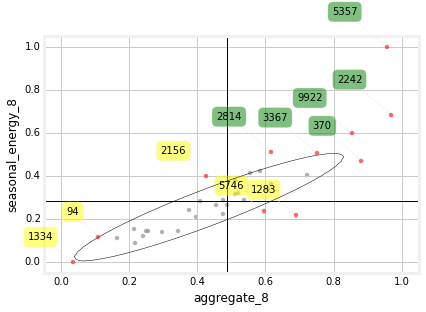

In [279]:
np.random.seed(10)
x = 'aggregate_8'
y = 'seasonal_energy_8'
t = 0.3
dfb = two_dim_anamoly(df_to_use,x,y,t)
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/anomaly_{}_{}_{}.png".format(x,y,t), bbox_inches="tight")

In [179]:
dfb.index

Int64Index([], dtype='int64')

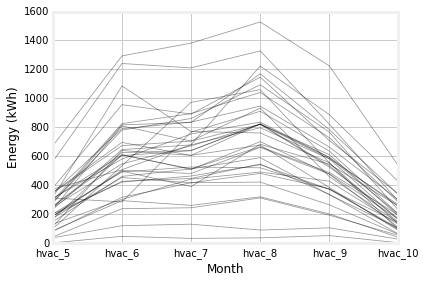

In [191]:
df_to_use[['hvac_5','hvac_6','hvac_7','hvac_8','hvac_9','hvac_10']].T.plot(legend=False, color='k',alpha=0.4, lw=0.8)
plt.xlabel("Month")
plt.ylabel("Energy (kWh)");
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/outlier_base.png")

In [194]:
df_to_use['hvac_8'][df_to_use['hvac_8']>np.percentile(df_to_use['hvac_8'], 95)]

2242    1327.652344
5357    1527.756836
Name: hvac_8, dtype: float64

In [195]:
df_to_use['hvac_8'][df_to_use['hvac_8']<np.percentile(df_to_use['hvac_8'], 5)]

94      88.738235
1334    34.965618
Name: hvac_8, dtype: float64

In [315]:
def dbscan_plot(df, x, y, min_samples=2, eps=0.05):
    from sklearn.cluster import DBSCAN
    cl = DBSCAN(min_samples=min_samples, eps=eps)
    XY=df[[x,y]].values
    cl.fit(XY)
    labels = cl.labels_
    core_samples_mask = np.zeros_like(cl.labels_, dtype=bool)
    core_samples_mask[cl.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = XY[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)

        xy = XY[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=6)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xlim((-0.05,1.05))
    plt.ylim((-0.05,1.05))
    
    # Plotting outliers now
    out_labels = df.ix[labels==-1].index.tolist()
    print out_labels
    for out_lab, x_coord, y_coord in zip(out_labels, df.ix[labels==-1][x], df.ix[labels==-1][y]):
        plt.annotate(
            out_lab, 
            xy = (x_coord, y_coord), xytext = (-30, 30),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.tight_layout()
    plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/cluster_{}_{}_{}_{}.png".format(x,y,min_samples, eps), bbox_inches="tight")

[1334, 2242, 5357, 9922]


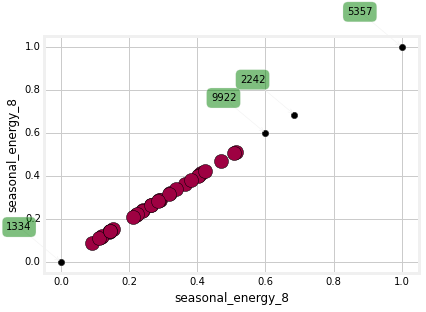

In [316]:
dbscan_plot(df_to_use, 'seasonal_energy_8','seasonal_energy_8',min_samples=2, eps=0.1)


In [286]:
df_to_use.ix[a==-1]

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,seasonal_energy_8,seasonal_energy_9,seasonal_energy_10,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
1334,0.054625,0.025869,0.056798,0.058401,0.039037,0.056366,0.052812,0.033859,0.070526,0.028826,...,0.000000,0.000000,0.000000,0.055118,0.3,0.4,0.000000,0.499285,0.044657,0.500715
2242,0.409781,0.252875,0.343166,0.354170,0.566372,0.918065,0.931476,0.969289,0.709792,0.398414,...,0.684959,0.683537,0.686050,1.000000,0.2,0.4,1.000000,0.355114,0.716414,0.644886
5357,0.928494,0.719195,0.736461,0.718856,0.759478,0.856505,0.936827,0.955660,0.862838,0.731150,...,1.000000,1.000000,1.000000,0.881890,0.5,1.0,0.158569,1.000000,0.256561,0.000000
9922,0.451495,0.397279,0.463080,0.516261,0.167925,0.367463,0.895846,0.852934,0.469251,0.198402,...,0.599777,0.597865,0.595636,0.527559,0.3,0.4,0.698364,0.255151,0.727921,0.744849


[370, 1334, 2242, 5357, 9922]


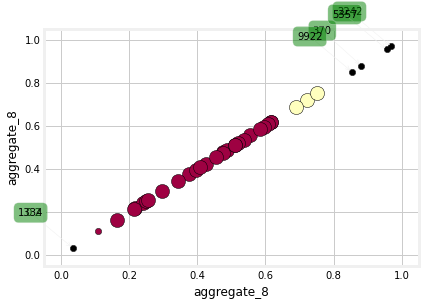

In [320]:
dbscan_plot(df_to_use, 'aggregate_8','aggregate_8',min_samples=3, eps=0.1)


In [225]:
cl.labels_

array([ 0, -1, -1, -1,  1,  2, -1, -1,  0,  3, -1, -1, -1,  4,  1, -1,  0,
        0,  4, -1,  0, -1,  0,  5,  0, -1,  2,  0, -1, -1,  3,  5, -1, -1,
       -1])

In [226]:
len(np.unique(cl.labels_))

7

In [10]:
XY = df_to_use[["aggregate_8", "seasonal_energy_8"]].values
X = df_to_use['aggregate_8'].values
Y = df_to_use['seasonal_energy_8'].values

In [11]:
from sklearn.covariance import EllipticEnvelope
classifiers = {
    "robust covariance estimator": EllipticEnvelope(contamination=.1)}

In [68]:
xx, yy = np.meshgrid(np.linspace(X.min() - 0.3, X.max() + 0.1, 500), np.linspace(Y.min() - 5, Y.max() + 5, 500))
outliers_fraction = 0.25
clusters_separation = [0]
n_samples = len(df_to_use)


In [69]:
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)


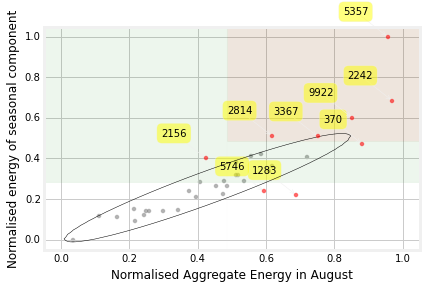

In [70]:
clf = EllipticEnvelope(contamination=.1)
# fit the data and tag outliers
clf.fit(XY)
y_pred = clf.decision_function(XY).ravel()
threshold = stats.scoreatpercentile(y_pred,
                                    100 * outliers_fraction)
y_pred = y_pred > threshold
# plot the levels lines and the points
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
subplot = plt.subplot(1, 1, 1)
a = subplot.contour(xx, yy, Z, levels=[threshold],
                        linewidths=0.5, colors='black',zorder=4)
df_outlier = df_to_use[~y_pred]
df_feedback = df_outlier[(df_outlier["aggregate_8"]>df["aggregate_8"].median())
                    & (df_outlier["seasonal_energy_8"]>df["seasonal_energy_8"].median())]

df_regular = df_to_use[y_pred]

df_outlier_no_feedback = df_outlier[(df_outlier["aggregate_8"]<=df_to_use["aggregate_8"].median())
                    | (df_outlier["seasonal_energy_8"]<=df["seasonal_energy_8"].median())]

subplot.scatter(df_regular["aggregate_8"],
                    df_regular["seasonal_energy_8"],
                    c='gray',alpha=0.6,zorder=0,lw=0.2)




subplot.scatter(df_outlier_no_feedback["aggregate_8"],
                    df_outlier_no_feedback["seasonal_energy_8"],
                    c='red',alpha=0.6,zorder=5,lw=0.2)

labels = df_outlier_no_feedback.index.tolist()
for label, x, y in zip(labels, df_outlier_no_feedback["aggregate_8"], df_outlier_no_feedback["seasonal_energy_8"]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

subplot.scatter(df_feedback["aggregate_8"],
                    df_feedback["seasonal_energy_8"],
                    c='red',alpha=0.6,zorder=5,lw=0.2)

labels = df_feedback.index.tolist()
for label, x, y in zip(labels, df_feedback["aggregate_8"], df_feedback["seasonal_energy_8"]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
    
subplot.axis('tight')
subplot.set_xlim((-0.05,1.05))
subplot.set_ylim((-0.05,1.05))
med_x = df_to_use["aggregate_8"].median()
plt.axhspan(df_to_use["seasonal_energy_8"].median(), df_to_use["seasonal_energy_8"].median(),alpha=0.5,lw=0.2)
plt.axvspan(med_x, df_to_use["aggregate_8"].median(),alpha=0.5,lw=0.2)
plt.axhspan(ymin=df_to_use["seasonal_energy_8"].median(), ymax=10,xmin=0.0,facecolor='green',edgecolor='green',alpha=0.07)
plt.axvspan(xmin=df_to_use["aggregate_8"].median(), xmax=2.6,ymin=df_to_use["aggregate_8"].median(),ymax=40,facecolor='red',edgecolor='green',alpha=0.07)
plt.xlabel("Normalised Aggregate Energy in August")
plt.ylabel("Normalised energy of seasonal component")

In [23]:
df_outlier

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,seasonal_energy_8,seasonal_energy_9,seasonal_energy_10,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
1283,0.258354,0.250395,0.233006,0.196870,0.334544,0.346118,0.428517,0.688576,0.535103,0.359545,...,0.219578,0.226749,0.221694,0.606299,0.8,1.0,0.321160,0.389172,0.491707,0.610828
2156,0.225887,0.169340,0.275184,0.201350,0.306517,0.401904,0.367288,0.424180,0.326950,0.189589,...,0.400825,0.403536,0.395114,0.322835,0.5,0.4,0.110829,0.543406,0.254840,0.456594
2242,0.409781,0.252875,0.343166,0.354170,0.566372,0.918065,0.931476,0.969289,0.709792,0.398414,...,0.684959,0.683537,0.686050,1.000000,0.2,0.4,1.000000,0.355114,0.716414,0.644886
2814,0.186413,0.170097,0.245559,0.262647,0.416523,0.626024,0.588941,0.616560,0.465465,0.290978,...,0.512694,0.515329,0.514908,0.354331,0.5,0.4,0.424991,0.369845,0.455928,0.630155
5357,0.928494,0.719195,0.736461,0.718856,0.759478,0.856505,0.936827,0.955660,0.862838,0.731150,...,1.000000,1.000000,1.000000,0.881890,0.5,1.0,0.158569,1.000000,0.256561,0.000000
5746,0.178093,0.130974,0.149107,0.188732,0.308979,0.474496,0.514058,0.594316,0.436375,0.263796,...,0.237970,0.238515,0.237165,0.318110,0.7,0.8,0.380147,0.299974,0.463341,0.700026
9922,0.451495,0.397279,0.463080,0.516261,0.167925,0.367463,0.895846,0.852934,0.469251,0.198402,...,0.599777,0.597865,0.595636,0.527559,0.3,0.4,0.698364,0.255151,0.727921,0.744849


In [25]:
df_feedback

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,seasonal_energy_8,seasonal_energy_9,seasonal_energy_10,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
2242,0.409781,0.252875,0.343166,0.354170,0.566372,0.918065,0.931476,0.969289,0.709792,0.398414,...,0.684959,0.683537,0.686050,1.000000,0.2,0.4,1.000000,0.355114,0.716414,0.644886
2814,0.186413,0.170097,0.245559,0.262647,0.416523,0.626024,0.588941,0.616560,0.465465,0.290978,...,0.512694,0.515329,0.514908,0.354331,0.5,0.4,0.424991,0.369845,0.455928,0.630155
5357,0.928494,0.719195,0.736461,0.718856,0.759478,0.856505,0.936827,0.955660,0.862838,0.731150,...,1.000000,1.000000,1.000000,0.881890,0.5,1.0,0.158569,1.000000,0.256561,0.000000
9922,0.451495,0.397279,0.463080,0.516261,0.167925,0.367463,0.895846,0.852934,0.469251,0.198402,...,0.599777,0.597865,0.595636,0.527559,0.3,0.4,0.698364,0.255151,0.727921,0.744849


In [72]:
df_feedback['hvac_8']

370     1169.249390
2242    1327.652344
2814    1093.281128
3367    1040.206787
5357    1527.756836
9922    1059.443359
Name: hvac_8, dtype: float64

In [77]:
df_outlier_no_feedback['hvac_8']

1283    1222.649170
2156     665.231506
5746     820.099365
Name: hvac_8, dtype: float64

In [33]:
np.percentile(df_to_use['hvac_8'], 90)

1160.0633056659999

In [75]:
df_to_use['hvac_8'][df_to_use['hvac_8']>np.percentile(df_to_use['hvac_8'], 80)]

370     1169.249390
545     1146.284180
1283    1222.649170
2242    1327.652344
2814    1093.281128
5357    1527.756836
9922    1059.443359
Name: hvac_8, dtype: float64

In [64]:
df_to_use[['hvac_8','aggregate_8','seasonal_energy_8']][df_to_use['aggregate_8']>0.6]

,hvac_8,aggregate_8,seasonal_energy_8
370,1169.249390,0.880712,0.470072
545,1146.284180,0.720570,0.406330
1283,1222.649170,0.688576,0.219578
2129,945.836487,0.617691,0.363705
2242,1327.652344,0.969289,0.684959
2814,1093.281128,0.616560,0.512694
3367,1040.206787,0.751478,0.508538
4767,835.039856,0.607234,0.338121
5357,1527.756836,0.955660,1.000000
9922,1059.443359,0.852934,0.599777
